In [1]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

import matplotlib.pyplot as plt
import matplotlib as mpl
# Set the global font to be Times New Roman
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['font.size'] = 12  

In [2]:
# load the data
df = pd.read_csv('data/data.csv')

# choose time period
df = df[(df.year_month > '2001-12') & (df.year_month < '2022-01')]

## 1. Summary statistics
---

In [3]:
cols = ['RET', 'Co2_tot', 'Intensity_tot', 'Marketcap', 'Levarage', 'B/M', 'RoE', 'Inves/AT', 'PPE', 'SaleGR', 'EPS', 'Staff_num', 'Firm_age']
summary_stats1 = df[cols].describe().T[['count','mean', 'std', 'min', '50%', 'max']]
summary_stats1.to_latex('results/summary_stats1.tex', float_format="{:.3f}".format)
summary_stats1

,count,mean,std,min,50%,max
RET,526393.0,1.304306e-02,1.470043e-01,-0.920559,0.009786,1.625053e+01
Co2_tot,526393.0,5.427269e+06,2.171045e+07,0.267797,401873.632825,4.144484e+08
Intensity_tot,526393.0,4.855482e+02,1.315781e+03,20.431643,148.242032,8.998684e+04
Marketcap,522812.0,3.205875e+05,1.379880e+07,0.007800,3666.730425,9.987323e+08
Levarage,522175.0,6.105285e-01,2.673633e-01,0.000828,0.605880,6.924882e+00
B/M,521618.0,5.206678e+00,9.370803e+02,-4127.449630,0.435844,2.746983e+05
RoE,521900.0,-1.376676e+00,2.159737e+02,-31837.000000,0.100978,3.887000e+02
Inves/AT,520278.0,4.111273e-02,5.345404e-02,-0.185768,0.025440,8.691516e-01
PPE,459439.0,1.059365e+04,3.544350e+04,0.000000,1416.100000,6.351491e+05
SaleGR,467731.0,1.745957e+00,9.670566e+01,-0.999884,0.063214,9.944997e+03


## 2. Number of firms and observations
---

In [4]:
# number of firms
n_firms = df.groupby('year').PERMNO.nunique().to_frame().reset_index()
# number of observations
n_firms['n_obs'] = df.groupby('year').PERMNO.count().values

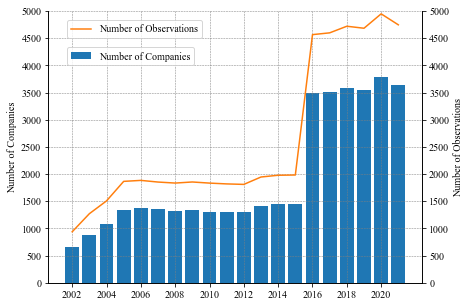

In [5]:
fig, ax1 = plt.subplots(1, 1, figsize=(6.7, 5))

# plot number of firms each year
ax1.bar(n_firms.year, n_firms.PERMNO, label='Number of Companies')
ax1.set_ylabel('Number of Companies')
ax1.set_ylim(0, 5000)

# secondary y-axis for n_obs
ax2 = ax1.twinx()
ax2.plot(n_firms.year, n_firms.n_obs/10, color='C1', label='Number of Observations')
ax2.set(ylabel='Number of Observations', ylim=(0, 5000))
ax2.set_yticks(range(0, 5001, 500))
ax2.set_xticks(range(2002, 2022, 2))

ax1.grid(color='gray', linestyle='--', linewidth=0.5)
ax1.set_yticks(range(0, 5001, 500))
ax1.set_xticks(range(2002, 2022, 2))

# set frames remove
ax1.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)

# legend location
ax1.legend(loc=(0.05, 0.8))
ax2.legend(loc=(0.05, 0.9))

plt.savefig('latex/graphics/number_obs.png', dpi=300)

## 3. Historical trend for co2 intensity and co2 emission
---

In [6]:
trend_co2 = df.groupby('year').Intensity_tot.mean().to_frame().reset_index(drop=False)
trend_co2['Co2_tot'] = df.groupby('year').Co2_tot.mean().values

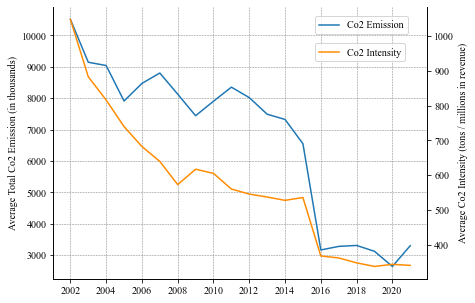

In [7]:
fig, ax1 = plt.subplots(1, 1, figsize=(6.7, 5))

ax1.plot(trend_co2.year, trend_co2.Co2_tot/1000, label='Co2 Emission')

ax2 = ax1.twinx()
ax2.plot(trend_co2.year, trend_co2.Intensity_tot, color='darkorange', label='Co2 Intensity')

ax1.grid(color='gray', linestyle='--', linewidth=0.5)
ax1.set_xticks(range(2002, 2022, 2))

ax1.set(ylabel='Average Total Co2 Emission (in thousands)')
ax2.set(ylabel='Average Co2 Intensity (tons / millions in revenue)')

ax1.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax1.legend(loc=(0.7, 0.9))
ax2.legend(loc=(0.7, 0.8))
plt.savefig('latex/graphics/co2_trend.png', dpi=300)

## 4. Industry Emission Ranking
---

In [8]:
industry = df.groupby('industry')['Co2_tot'].mean().to_frame()

industry = industry.reset_index()
industry = industry.sort_values('Co2_tot', ascending=False)

industry['rank'] = np.arange(1, len(industry) + 1)

industry['co2_total'] = industry['Co2_tot'].div(1000000).round(2)
industry = industry[['rank', 'industry', 'co2_total']]
industry.columns = ['Rank', 'GICS Industry Name', 'Total CO2 Emission']
industry_rank = pd.concat([industry[industry['Rank']<=37].reset_index(drop=True), industry[industry['Rank']>37].reset_index(drop=True)], axis=1)
industry_rank.to_latex('results/industry_rank.tex', index=False)
industry_rank.head(5)

,Rank,GICS Industry Name,Total CO2 Emission,Rank,GICS Industry Name,Total CO2 Emission
0,1,Independent Power and Renewable Electricity Pr...,38.15,38,"Electronic Equipment, Instruments and Components",1.23
1,2,Electric Utilities,37.46,39,Semiconductors and Semiconductor Equipment,1.11
2,3,Automobiles,30.04,40,Specialty Retail,1.09
3,4,"Oil, Gas and Consumable Fuels",28.28,41,"Textiles, Apparel and Luxury Goods",1.08
4,5,Multi-Utilities,21.05,42,Construction and Engineering,1.07


In [9]:
#print(industry_rank.to_latex(index=False, float_format='%0.2f'))

## 5. Return distribution
---
### 5.1 Based on Co2 emission

In [10]:
# return in percentage
df['RET'] = df.RET * 100 
df['percentiles'] = df.Co2_tot.transform(lambda x: pd.qcut(x, q=100, labels=range(1, 101)))
co2_tot = df.groupby('percentiles', observed=True).RET.mean().to_frame()

df['percentiles'] = df.Co2_scope1.transform(lambda x: pd.qcut(x, q=100, labels=range(1, 101)))
co2_scope1 = df.groupby('percentiles', observed=True).RET.mean().to_frame()

df['percentiles'] = df.Co2_scope2.transform(lambda x: pd.qcut(x, q=100, labels=range(1, 101)))
co2_scope2 = df.groupby('percentiles', observed=True).RET.mean().to_frame()

df['percentiles'] = df.Co2_scope3.transform(lambda x: pd.qcut(x, q=100, labels=range(1, 101)))
co2_scope3 = df.groupby('percentiles', observed=True).RET.mean().to_frame()

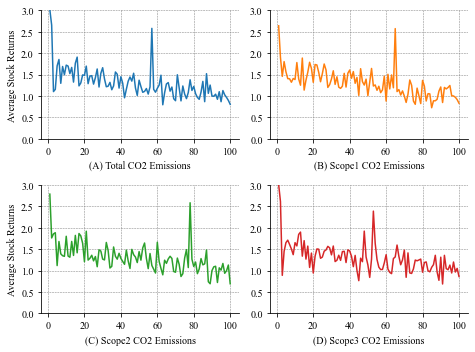

In [11]:
fig, axe = plt.subplots(2,2, figsize=(6.7,5))

axe[0,0].plot(co2_tot.RET, color='C0')
axe[0,0].set_xlabel('(A) Total CO2 Emissions')
axe[0,0].set_ylabel('Average Stock Returns')

axe[0,1].plot(co2_scope1.RET, color='C1')
axe[0,1].set_xlabel('(B) Scope1 CO2 Emissions')
axe[0,1].set_ylabel('')

axe[1,0].plot(co2_scope2.RET, color='C2')
axe[1,0].set_xlabel('(C) Scope2 CO2 Emissions')
axe[1,0].set_ylabel('Average Stock Returns')

axe[1,1].plot(co2_scope3.RET, color='C3')
axe[1,1].set_xlabel('(D) Scope3 CO2 Emissions')
axe[1,1].set_ylabel('')

for a in range(0, 2):
    for b in range(0, 2):
        axe[a, b].grid(color='gray', linestyle='--', linewidth=0.5)
        axe[a, b].spines[['top', 'right']].set_visible(False)
        axe[a, b].set(ylim=(0, 3))

plt.tight_layout() # automatically adjust the width height ratio
plt.savefig('latex/graphics/co2_percentile.png', dpi=300)

### 5.2 Based on co2 intensity

In [12]:
df['percentiles'] = df.Intensity_tot.transform(lambda x: pd.qcut(x, q=100, labels=range(1, 101)))
intensity_tot = df.groupby('percentiles', observed=True).RET.mean().to_frame()

df['percentiles'] = df.Intensity_scope1.transform(lambda x: pd.qcut(x, q=100, labels=range(1, 101)))
intensity_scope1 = df.groupby('percentiles', observed=True).RET.mean().to_frame()

df['percentiles'] = df.Intensity_scope2.transform(lambda x: pd.qcut(x, q=100, labels=range(1, 101)))
intensity_scope2 = df.groupby('percentiles', observed=True).RET.mean().to_frame()

df['percentiles'] = df.Intensity_scope3.transform(lambda x: pd.qcut(x, q=100, labels=range(1, 101)))
intensity_scope3 = df.groupby('percentiles', observed=True).RET.mean().to_frame()

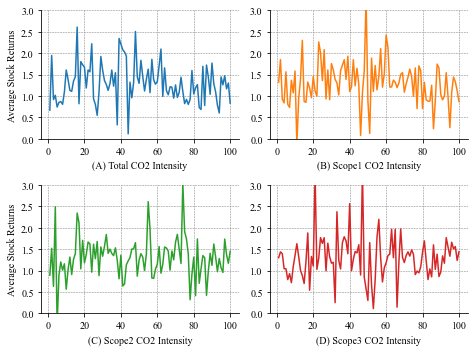

In [13]:
fig, axe = plt.subplots(2,2, figsize=(6.7,5))

axe[0,0].plot(intensity_tot.RET, color='C0')
axe[0,0].set_xlabel('(A) Total CO2 Intensity')
axe[0,0].set_ylabel('Average Stock Returns')

axe[0,1].plot(intensity_scope1.RET, color='C1')
axe[0,1].set_xlabel('(B) Scope1 CO2 Intensity')
axe[0,1].set_ylabel('')

axe[1,0].plot(intensity_scope2.RET, color='C2')
axe[1,0].set_xlabel('(C) Scope2 CO2 Intensity')
axe[1,0].set_ylabel('Average Stock Returns')

axe[1,1].plot(intensity_scope3.RET, color='C3')
axe[1,1].set_xlabel('(D) Scope3 CO2 Intensity')
axe[1,1].set_ylabel('')

for a in range(0, 2):
    for b in range(0, 2):
        axe[a, b].grid(color='gray', linestyle='--', linewidth=0.5)
        axe[a, b].spines[['top', 'right']].set_visible(False)
        axe[a, b].set(ylim=(0, 3))

plt.tight_layout() # automatically adjust the width height ratio
plt.savefig('latex/graphics/int_percentile.png', dpi=300)

### 5.3 Based on other factors

In [14]:
df['percentiles'] = df.Marketcap.transform(lambda x: pd.qcut(x, q=100, labels=range(1, 101)))
Marketcap = df.groupby('percentiles', observed=True).RET.mean().to_frame()

df['percentiles'] = df.Levarage.transform(lambda x: pd.qcut(x, q=100, labels=range(1, 101)))
Levarage = df.groupby('percentiles', observed=True).RET.mean().to_frame()

df['percentiles'] = df.RoE.transform(lambda x: pd.qcut(x, q=100, labels=range(1, 101)))
RoE = df.groupby('percentiles', observed=True).RET.mean().to_frame()

df['percentiles'] = df.SaleGR.transform(lambda x: pd.qcut(x, q=100, labels=range(1, 101)))
SaleGR = df.groupby('percentiles', observed=True).RET.mean().to_frame()

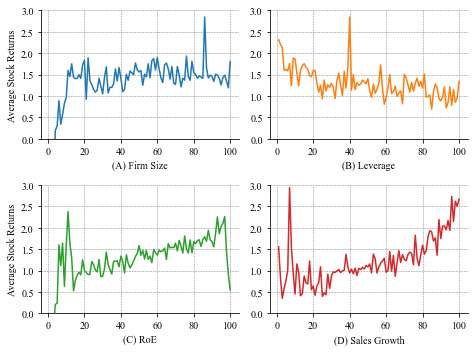

In [15]:
fig, axe = plt.subplots(2,2, figsize=(6.7,5))

axe[0,0].plot(Marketcap.RET, color='C0')
axe[0,0].set_xlabel('(A) Firm Size')
axe[0,0].set_ylabel('Average Stock Returns')

axe[0,1].plot(Levarage.RET, color='C1')
axe[0,1].set_xlabel('(B) Leverage')
axe[0,1].set_ylabel('')

axe[1,0].plot(RoE.RET, color='C2')
axe[1,0].set_xlabel('(C) RoE')
axe[1,0].set_ylabel('Average Stock Returns')

axe[1,1].plot(SaleGR.RET, color='C3')
axe[1,1].set_xlabel('(D) Sales Growth')
axe[1,1].set_ylabel('')

for a in range(0, 2):
    for b in range(0, 2):
        axe[a, b].grid(color='gray', linestyle='--', linewidth=0.5)
        axe[a, b].spines[['top', 'right']].set_visible(False)
        axe[a, b].set(ylim=(0, 3))

plt.tight_layout() # automatically adjust the width height ratio
plt.savefig('latex/graphics/other_percentile.png', dpi=300)

## 6. Green and brown portfolios
---
### 6.1 Greenness based on co2 emission

In [16]:
# compute weights
df['mc_sum'] = df.groupby(['year_month', 'greenness_co2_industry']).Marketcap.transform('sum')
df['weights'] = df.Marketcap / df.mc_sum

# value weighted returns
df['vw_return'] = df.RET * df.weights

# value weighted return for portfolios with different greenness
vw_return = df.groupby(['year_month', 'greenness_co2_industry'])['vw_return'].sum().to_frame().reset_index()

# pivot to wide data
vw_return_co2 = vw_return.pivot(index='year_month', columns='greenness_co2_industry', values='vw_return').reset_index()

vw_return_co2.columns = ['year_month', 'Green', 'A', 'Netrual', 'B', 'Brown']

vw_return_co2[['Green', 'A', 'Netrual', 'B', 'Brown']] = vw_return_co2[['Green', 'A', 'Netrual', 'B', 'Brown']].cumsum()
vw_return_co2['year_month'] = pd.to_datetime(vw_return_co2['year_month'], format='%Y-%m')

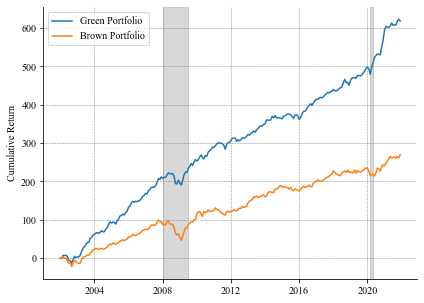

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(6.7, 5))

# load nber recession data
nber = pd.read_excel('data/raw_data/NBER_recession.xlsx')
nber['Peak'] = pd.PeriodIndex(nber.Peak, freq='M')
nber = nber[nber.Peak > '1971-11']
nber['Trough'] = pd.PeriodIndex(nber[' Trough'], freq='M')

ax.plot(vw_return_co2.year_month, vw_return_co2.Green, label='Green Portfolio')
ax.plot(vw_return_co2.year_month, vw_return_co2.Brown, label='Brown Portfolio')

for i in range(6, 8):
 ax.axvspan(nber['Peak'][i], nber['Trough'][i], alpha=0.3, color='grey')

ax.legend()
ax.grid(color='gray', linestyle='--', linewidth=0.5)
ax.spines[['top', 'right']].set_visible(False)
ax.set(ylabel='Cumulative Return')
plt.savefig('latex/graphics/green_brown_co2.png', dpi=300)

### 6.2 Greenness based on carbon intensity

In [20]:
# compute weights
df['mc_sum'] = df.groupby(['year_month', 'greenness_int_industry']).Marketcap.transform('sum')
df['weights'] = df.Marketcap / df.mc_sum

# value weighted returns
df['vw_return'] = df.RET * df.weights

# value weighted return for portfolios with different greenness
vw_return = df.groupby(['year_month', 'greenness_int_industry'])['vw_return'].sum().to_frame().reset_index()

# pivot to wide data
vw_return_int = vw_return.pivot(index='year_month', columns='greenness_int_industry', values='vw_return').reset_index()

vw_return_int.columns = ['year_month', 'Green', 'A', 'Netural', 'B', 'Brown']

vw_return_int[['Green', 'A', 'Netural', 'B', 'Brown']] = vw_return_int[['Green', 'A', 'Netural', 'B', 'Brown']].cumsum()
vw_return_int['year_month'] = pd.to_datetime(vw_return_int['year_month'], format='%Y-%m')

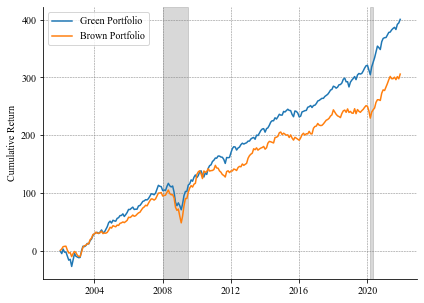

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(6.7, 5))

ax.plot(vw_return_int.year_month, vw_return_int.Green, label='Green Portfolio')
ax.plot(vw_return_int.year_month, vw_return_int.Brown, label='Brown Portfolio')

for i in range(6, 8):
 ax.axvspan(nber['Peak'][i], nber['Trough'][i], alpha=0.3, color='grey')

ax.legend()
ax.grid(color='gray', linestyle='--', linewidth=0.5)
ax.spines[['top', 'right']].set_visible(False)
ax.set(ylabel='Cumulative Return')
plt.savefig('latex/graphics/green_brown_int.png', dpi=300)

## 7. Regression analysis
---

In [20]:
# construct value-weighted portfolios
df['mc_sum'] = df.groupby(['year_month', 'greenness_co2_industry']).Marketcap.transform('sum')
df['weights'] = df.Marketcap / df.mc_sum

# value weighted returns
df['vw_return'] = df.RET * df.weights

# value weighted return for portfolios with different greenness
vw_return = df.groupby(['year_month', 'greenness_co2_industry'])['vw_return'].sum().to_frame().reset_index()

# pivot to wide data
vw_return_wide = vw_return.pivot(index='year_month', columns='greenness_co2_industry', values='vw_return').reset_index()

vw_return_wide.columns = ['year_month', 'Green', 'A', 'netural', 'B', 'Brown']

# green-brown portfolio
vw_return_wide['Green_Brown'] = vw_return_wide['Green'] - vw_return_wide['Brown']

# load data
index_ = pd.read_csv('data/raw_data/index.csv')
index_['year_month'] = pd.PeriodIndex(index_.year_month, freq='M').astype(str)

# merge data
green_brown_co2 = pd.merge(vw_return_wide, index_, how='inner')

In [21]:
# green-brown based on CO2 emission
# model 1 with only intercept
model1 = sm.OLS.from_formula('Green_Brown ~ 1', data=green_brown_co2)
fit1 = model1.fit()

# model 2 with ff3 factors
model2 = sm.OLS.from_formula('Green_Brown ~ 1 + Mkt_RF + SMB + HML', data=green_brown_co2)
fit2 = model2.fit()

# model 3 with ff5 factors
model3 = sm.OLS.from_formula('Green_Brown ~ 1 + Mkt_RF + SMB + HML + RMW + CMA', data=green_brown_co2)
fit3 = model3.fit()

# model 4 with ff5 + mom + liq
model4 = sm.OLS.from_formula('Green_Brown ~ 1 + Mkt_RF + SMB + HML + RMW + CMA + MOM + LIQ', data=green_brown_co2)
fit4 = model4.fit(use_t=True)

In [22]:
# construct value-weighted portfolios
df['mc_sum'] = df.groupby(['year_month', 'greenness_int_industry']).Marketcap.transform('sum')
df['weights'] = df.Marketcap / df.mc_sum

# value weighted returns
df['vw_return'] = df.RET * df.weights

# value weighted return for portfolios with different greenness
vw_return = df.groupby(['year_month', 'greenness_int_industry'])['vw_return'].sum().to_frame().reset_index()

# pivot to wide data
vw_return_wide = vw_return.pivot(index='year_month', columns='greenness_int_industry', values='vw_return').reset_index()

vw_return_wide.columns = ['year_month', 'Green', 'A', 'netural', 'B', 'Brown']

# green-brown portfolio
vw_return_wide['Green_Brown'] = vw_return_wide['Green'] - vw_return_wide['Brown']

# load data
index_ = pd.read_csv('data/raw_data/index.csv')
index_['year_month'] = pd.PeriodIndex(index_.year_month, freq='M').astype(str)

# merge data
green_brown_int = pd.merge(vw_return_wide, index_, how='inner')

In [23]:
# green-brown based on Intensity
# model 5 with only intercept
model5 = sm.OLS.from_formula('Green_Brown ~ 1', data=green_brown_int)
fit5 = model5.fit()

# model 6 with ff3 factors
model6 = sm.OLS.from_formula('Green_Brown ~ 1 + Mkt_RF + SMB + HML', data=green_brown_int)
fit6 = model6.fit()

# model 7 with ff5 factors
model7 = sm.OLS.from_formula('Green_Brown ~ 1 + Mkt_RF + SMB + HML + RMW + CMA', data=green_brown_int)
fit7 = model7.fit()

# model  with ff5 + mom + liq
model8 = sm.OLS.from_formula('Green_Brown ~ 1 + Mkt_RF + SMB + HML + RMW + CMA + MOM + LIQ', data=green_brown_int)
fit8 = model8.fit()

In [30]:
summary_table = summary_col([fit1, fit2, fit3, fit4, fit5, fit6, fit7, fit8], 
                            stars=True, 
                            float_format='%.3f',
                            model_names=['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'Model 6', 'Model7', 'Model8'],
                            info_dict={'N': lambda x: f"{int(x.nobs)}"},
                            regressor_order=['Intercept', 'Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA', 'MOM', 'LIQ'])
print(summary_table.as_latex())

\begin{table}
\caption{}
\label{}
\begin{center}
\begin{tabular}{lllllllll}
\hline
               & Model 1  & Model 2   & Model 3   & Model 4   & Model 5 & Model 6   & Model7    & Model8     \\
\hline
Intercept      & 1.454*** & 1.169***  & 1.181***  & 1.073***  & 0.395*  & 0.124     & 0.080     & 0.016      \\
               & (0.319)  & (0.268)   & (0.280)   & (0.298)   & (0.234) & (0.209)   & (0.218)   & (0.233)    \\
Mkt\_RF        &          & 0.072     & 0.070     & 0.120     &         & 0.251***  & 0.266***  & 0.289***   \\
               &          & (0.065)   & (0.069)   & (0.073)   &         & (0.051)   & (0.054)   & (0.057)    \\
SMB            &          & 1.092***  & 1.078***  & 1.039***  &         & 0.199**   & 0.200**   & 0.185**    \\
               &          & (0.113)   & (0.119)   & (0.119)   &         & (0.088)   & (0.092)   & (0.093)    \\
HML            &          & -0.543*** & -0.554*** & -0.470*** &         & -0.575*** & -0.625*** & -0.591***  \\
              

### 7.2 Regression analysis with MCCC index

In [31]:
index_ = pd.read_csv('data/raw_data/index.csv')
index_['year_month'] = pd.PeriodIndex(index_.year_month, freq='M').astype(str)

# shift columns
col_shift = ['Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA', 'sent', 'wti', 'CFNAI', 'vix']
index_[col_shift] = index_[col_shift].shift(1)

index_['mccc_lag1'] = index_.mccc.shift(1)

# drop nas
index_.dropna(inplace=True)

# use ARC model to get umc
arx_model = sm.OLS.from_formula('mccc ~ 1 + mccc_lag1 + Mkt_RF + SMB + HML + RMW + CMA + sent + wti + CFNAI + vix', data=index_)
arx_fit = arx_model.fit()

index_['umc'] = index_.mccc - arx_fit.predict()

index_ = index_[['year_month', 'umc']]

# merge
umc_merged = pd.merge(index_, green_brown_co2, how='right')

In [32]:
# Green - Brown
model1 = sm.OLS.from_formula('Green_Brown ~ 1 + umc + Mkt_RF + SMB + HML + RMW + CMA + sent + wti + CFNAI + vix', data=umc_merged)
fit1 = model1.fit()

# Green
model2 = sm.OLS.from_formula('Green ~ 1 + umc + Mkt_RF + SMB + HML + RMW + CMA + sent + wti + CFNAI + vix', data=umc_merged)
fit2 = model2.fit()

# Green
model3 = sm.OLS.from_formula('Brown ~ 1 + umc + Mkt_RF + SMB + HML + RMW + CMA + sent + wti + CFNAI + vix', data=umc_merged)
fit3 = model3.fit()

# Neutral
model4 = sm.OLS.from_formula('netural ~ 1 + umc + Mkt_RF + SMB + HML + RMW + CMA + sent + wti + CFNAI + vix', data=umc_merged)
fit4 = model4.fit()

In [34]:
summary_table = summary_col([fit1, fit2, fit3, fit4], 
                            stars=True, 
                            float_format='%.3f',
                            model_names=['Green-Brown', 'Green', 'Brown', 'Neutral'],
                            info_dict={'N': lambda x: f"{int(x.nobs)}"},
                            regressor_order=['Intercept', 'umc', 'Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA', 'sent', 'wti', 'CFNAI', 'vix'])
print(summary_table.as_latex())

\begin{table}
\caption{}
\label{}
\begin{center}
\begin{tabular}{lllll}
\hline
               & Green-Brown & Green    & Brown     & Neutral   \\
\hline
Intercept      & 1.310       & 1.665**  & 0.355     & 1.040**   \\
               & (1.179)     & (0.844)  & (0.857)   & (0.430)   \\
umc            & 3.049***    & 1.786**  & -1.263*   & -0.029    \\
               & (1.029)     & (0.736)  & (0.748)   & (0.375)   \\
Mkt\_RF        & 0.083       & 0.920*** & 0.837***  & 0.965***  \\
               & (0.080)     & (0.057)  & (0.058)   & (0.029)   \\
SMB            & 1.079***    & 0.724*** & -0.355*** & 0.318***  \\
               & (0.133)     & (0.095)  & (0.096)   & (0.048)   \\
HML            & -0.557***   & -0.216** & 0.341***  & -0.008    \\
               & (0.122)     & (0.088)  & (0.089)   & (0.045)   \\
RMW            & -0.164      & -0.198*  & -0.033    & -0.024    \\
               & (0.167)     & (0.119)  & (0.121)   & (0.061)   \\
CMA            & 0.112       & 0.041    & -

## 8. MCCC index
---

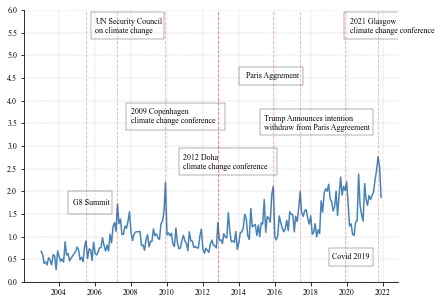

In [41]:
mpl.rcParams['font.size'] = 8

# load data
index = pd.read_csv('data/raw_data/index.csv')
index = index[(index['year_month'] > '2001-12') & (index['year_month'] < '2022-01')]
index['year_month'] = pd.to_datetime(index['year_month'])

fig, ax = plt.subplots(figsize=(6.7, 5))

# Line plot
ax.plot(index['year_month'], index['mccc'], color='steelblue')

# Y-axis limits and breaks
ax.set_ylim(0, 6)
ax.set_yticks([i * 0.5 for i in range(13)])
ax.spines[['top', 'right']].set_visible(False)
ax.yaxis.grid(True, which='major', color='gray', linestyle='--', linewidth=0.2)
ax.xaxis.grid(True, which='major', color='gray', linestyle='--', linewidth=0.2)


# Adding annotations and vertical lines
ax.axvline(pd.to_datetime('2005-07-01'), linestyle='dashed', color='red', alpha=0.3, linewidth=0.9)
ax.add_patch(plt.Rectangle((pd.to_datetime('2004-07-01'), 1.5), pd.Timedelta('900D'), 0.5, fill=True, facecolor='white', edgecolor='black', linewidth=0.3))
ax.text(pd.to_datetime('2004-10-01'), 1.7, 'G8 Summit', fontsize=8)

ax.axvline(pd.to_datetime('2007-04-01'), linestyle='dashed', color='red', alpha=0.3, linewidth=0.9)
ax.add_patch(plt.Rectangle((pd.to_datetime('2005-10-01'), 5.35), pd.Timedelta('1500D'), 0.6, fill=True, facecolor='white', edgecolor='black', linewidth=0.3))
ax.text(pd.to_datetime('2006-01-01'), 5.5, 'UN Security Council \non climate change', fontsize=8)

ax.axvline(pd.to_datetime('2009-12-01'), linestyle='dashed', color='red', alpha=0.3, linewidth=0.9)
ax.add_patch(plt.Rectangle((pd.to_datetime('2007-10-01'), 3.35), pd.Timedelta('2000D'), 0.6, fill=True, facecolor='white', edgecolor='black', linewidth=0.3))
ax.text(pd.to_datetime('2008-01-01'), 3.5, '2009 Copenhagen \nclimate change conference', fontsize=8)

ax.axvline(pd.to_datetime('2012-11-01'), linestyle='dashed', color='red', alpha=0.3, linewidth=0.9)
ax.add_patch(plt.Rectangle((pd.to_datetime('2010-09-01'), 2.35), pd.Timedelta('2000D'), 0.6, fill=True, facecolor='white', edgecolor='black', linewidth=0.3))
ax.text(pd.to_datetime('2010-12-01'), 2.5, '2012 Doha \nclimate change conference', fontsize=8)

ax.axvline(pd.to_datetime('2015-12-01'), linestyle='dashed', color='red', alpha=0.3, linewidth=0.9)
ax.add_patch(plt.Rectangle((pd.to_datetime('2014-01-01'), 4.35), pd.Timedelta('1300D'), 0.4, fill=True, facecolor='white', edgecolor='black', linewidth=0.3))
ax.text(pd.to_datetime('2014-06-01'), 4.5, 'Paris Aggrement', fontsize=8)

ax.axvline(pd.to_datetime('2017-06-01'), linestyle='dashed', color='red', alpha=0.3, linewidth=0.9)
ax.add_patch(plt.Rectangle((pd.to_datetime('2015-03-01'), 3.25), pd.Timedelta('2300D'), 0.56, fill=True, facecolor='white', edgecolor='black', linewidth=0.3))
ax.text(pd.to_datetime('2015-06-01'), 3.35, 'Trump Announces intention \nwithdraw from Paris Aggreement', fontsize=8)

ax.axvline(pd.to_datetime('2019-12-01'), linestyle='dashed', color='red', alpha=0.3, linewidth=0.9)
ax.add_patch(plt.Rectangle((pd.to_datetime('2019-01-01'), 0.35), pd.Timedelta('900D'), 0.4, fill=True, facecolor='white', edgecolor='black', linewidth=0.3))
ax.text(pd.to_datetime('2019-03-01'), 0.5, 'Covid 2019', fontsize=8)

ax.axvline(pd.to_datetime('2021-10-01'), linestyle='dashed', color='red', alpha=0.3, linewidth=0.9)
ax.axvline(pd.to_datetime('2012-11-01'), linestyle='dashed', color='red', alpha=0.3, linewidth=0.9)
ax.add_patch(plt.Rectangle((pd.to_datetime('2019-11-01'), 5.35), pd.Timedelta('1600D'), 0.6, fill=True, facecolor='white', edgecolor='black', linewidth=0.3))
ax.text(pd.to_datetime('2020-03-01'), 5.5, '2021 Glasgow \nclimate change conference', fontsize=8)

plt.savefig('latex/graphics/mccc.png', dpi=300)